In [10]:
# v?? 19 Oct 2023 

# nu / np.pi yes
# batch_size [1024, 1024, 1024]
# lr = 0.005
# learned_nu at around 0.0001
# learnabe alpha

####################### cannot learn t_shock and std_dev #######################

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata

class Domain:
    def __init__(self, x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v, batch_size):
        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.num_x = num_x
        self.num_t = num_t
        self.batch_size_r = batch_size[0]
        self.batch_size_0 = batch_size[1]
        self.batch_size_b = batch_size[2]
        self.viscosity = tf.Variable(initial_value=viscosity_init_v, 
                                     trainable=True, 
                                     dtype=tf.float32,
                                     name="artificial_viscosity")
        self.alpha = tf.Variable(initial_value=tf.ones([]) * 1.0,
                                 trainable=True,
                                 dtype=tf.float32,
                                 name="nu_loss_coefficient")
        self.t_shock = tf.Variable(initial_value=0.5, 
                                   trainable=True,
                                   dtype=tf.float32,
                                   name="shock_happen_time")
        self.std_dev = tf.Variable(initial_value=0.3,
                                   trainable=True,
                                   dtype=tf.float32,
                                   name="standard_deviation_for_GD")
    
# Define the initial condition
def initial_condition(domain, x):
    # initial_output = np.where(x > 0, 1, 0)
    initial_output = -np.sin(np.pi * x)
    return initial_output 

# Define the boundary conditions
def boundary_conditions(domain, x, t):
    return np.zeros_like(x)

def viscosity_mapping(x, t):
    nu_map = np.where(t >= domain.t_shock, np.exp(-((x - 0) ** 2) / (2 * domain.std_dev ** 2)), 0) # * domain.theta  # gaussian_distribution
    scaled_nu_map = (nu_map - np.min(nu_map)) / (np.max(nu_map) - np.min(nu_map))
    viscosity = domain.viscosity * scaled_nu_map # tf.sigmoid(nu_map)
    storage = [x, t, nu_map, viscosity] # parameter_s components: 0x, 1t, 2theta, 3nu, 4epoch
    return storage 

# Define the physics-informed loss function
def physics_informed_loss(network, domain, x, t, batch_size):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        t_shock_broadcasted = tf.fill(x.shape, domain.t_shock) # make shape compatible for the network inputs [epoch_number,1]
        std_dev_broadcasted = tf.fill(x.shape, domain.std_dev) # make shape compatible for the network inputs [epoch_number,1]
        u = network(tf.concat([x, t, t_shock_broadcasted, std_dev_broadcasted], axis=1))

        u_x = tape.gradient(u, x) # cancel: Reshape x to [32,1]
        u_t = tape.gradient(u, t) # solved: u_t showed NoneType
        u_xx = tape.gradient(u_x, x)

        # Debugging: Check if any tensors contain NaN values
        tf.debugging.assert_all_finite(u_x, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_t, "u_t contains NaN values")

        # define the parametric viscosity map with the collocation points in the residual learning batch
        # keep record of the parameters: x_coords, t_coords, theta, product of nu_max and nu_map
        parameter_storage = viscosity_mapping(x, t)

        # Define the Burgers equation residual
        residual = u_t + u * u_x - parameter_storage[3] * u_xx
    
    # Define the boundary and initial condition residuals # Done_TODO check "u" LR
    # Compute the loss for initial condition
    num_batch_size_0 = domain.batch_size_0
    t_batch_0 = tf.fill([num_batch_size_0, 1], 0.0001) # considered as 0
    x_batch_0 = tf.random.uniform([num_batch_size_0, 1], minval=domain.x_min, maxval=domain.x_max)
    u_0 = network(tf.concat([x_batch_0, t_batch_0, 
                             tf.fill(x_batch_0.shape, domain.t_shock), 
                             tf.fill(x_batch_0.shape, domain.std_dev)], axis=1))
    initial_residual = u_0 - initial_condition(domain, x_batch_0)

    # Compute the loss for boundary condition
    num_batch_size_b = domain.batch_size_b
    x_batch_bl = tf.cast(tf.fill([num_batch_size_b, 1], -1), dtype=tf.float32)
    x_batch_br = tf.cast(tf.fill([num_batch_size_b, 1], 1), dtype=tf.float32)
    t_batch_b  = tf.random.uniform([num_batch_size_b, 1], minval=domain.t_min, maxval=domain.t_max)
    u_bl = network(tf.concat([x_batch_bl, t_batch_b, 
                              tf.fill(x_batch_bl.shape, domain.t_shock), 
                              tf.fill(x_batch_bl.shape, domain.std_dev)], axis=1)) # int32 and float incompatible
    u_br = network(tf.concat([x_batch_br, t_batch_b, 
                              tf.fill(x_batch_br.shape, domain.t_shock),
                              tf.fill(x_batch_br.shape, domain.std_dev)], axis=1))
    lower_boundary_residual = u_bl - boundary_conditions(domain, x_batch_bl, t_batch_b)
    upper_boundary_residual = u_br - boundary_conditions(domain, x_batch_br, t_batch_b)

    viscosity_loss = tf.square(domain.viscosity) 

    loss = tf.reduce_mean(tf.square(residual)) / batch_size + \
           tf.reduce_mean(tf.square(initial_residual)) / num_batch_size_0 + \
           tf.reduce_mean(tf.square(lower_boundary_residual)) / num_batch_size_b + \
           tf.reduce_mean(tf.square(upper_boundary_residual)) / num_batch_size_b + \
            domain.alpha * viscosity_loss
    
    return loss, parameter_storage

# Define the neural network model
def create_network():
    network = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(4,)),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    return network

# Train the model using PINNs
def train_model(network, domain, num_epochs, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Lists to store loss and viscosity values for each epoch
    history = [[] for _ in range(3)]  # Initialize history as a list with three empty lists
    # history components, [0]: loss, [1]: nu, [2]: alpha

    for epoch in range(num_epochs):
        x_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.x_min, maxval=domain.x_max)
        t_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.t_min, maxval=domain.t_max)

        with tf.GradientTape() as tape:
            loss, parameter_s = physics_informed_loss(network, domain, x_batch, t_batch, domain.batch_size_r)

        # add viscosity into the trainable variables from TF
        variable_list = network.trainable_variables + [domain.viscosity] + [domain.alpha]

        gradients = tape.gradient(loss, variable_list)
        # # Update αvisc based on negative gradient
        # alpha_update = -learning_rate * gradients[-1]  # Negative gradient ascent
        # domain.alpha.assign_add(alpha_update)

        # # Apply gradients to the network weights
        # # optimizer.apply_gradients(zip(gradients[:-2], variable_list[:-2]))
        optimizer.apply_gradients(zip(gradients, variable_list))

        # if epoch % 100 == 0:
        #     print(f"Epoch {epoch}, Loss: {loss.numpy()}")

        if epoch % 10 == 0:
            # Append the loss and viscosity values to the history lists
            history[0].append(loss.numpy())
            history[1].append(domain.viscosity.numpy())
            history[2].append(domain.alpha.numpy())
    
    return network, history, parameter_s

# Visualize the results
def visualize_results(model, domain, history, num_epochs, parameter_s):
    x_grid, t_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                                 np.linspace(domain.t_min, domain.t_max, domain.num_t))
    t_shock_grid = np.full_like(x_grid, domain.t_shock)
    std_dev_grid = np.full_like(x_grid, domain.std_dev)
    X = np.hstack((x_grid.flatten()[:, tf.newaxis], 
                   t_grid.flatten()[:, tf.newaxis], 
                   t_shock_grid.flatten()[:, tf.newaxis],
                   std_dev_grid.flatten()[:, tf.newaxis]))
    u_pred_grid = model.predict(X)
    u_pred_grid = griddata(X[:, 0:2], u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(x_grid, t_grid, u_pred_grid, cmap='viridis')

    # Set labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(x, t)')
    plt.title('Plot of u(x, t)')
    plt.show()

    # print("u_pred_shape:", u_pred_grid.shape)

    plt.figure(figsize=(8, 6))
    plt.pcolor(x_grid, t_grid, u_pred_grid, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Velocity')
    plt.show()

    # Define the x-axis labels at intervals of every 10 epochs
    x_labels = list(range(0, num_epochs, 10))

    # Plot the loss and viscosity trajectories
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_labels, history[0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trajectory')

    plt.subplot(1, 2, 2)
    plt.plot(x_labels, history[1])
    plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')
    plt.xlabel('Epoch')
    plt.ylabel('Viscosity')
    plt.title('Viscosity Trajectory')

    plt.figure(figsize=(6, 6))
    plt.plot(x_labels, history[2])
    plt.xlabel('Epoch')
    plt.ylabel('alpha')
    plt.title('Alpha Trajectory')

    plt.legend()
    plt.tight_layout()
    plt.show()


    # plot the viscosity map
    # parameter_s components: 0x, 1t, 2nu_map, 3nu, 4epoch
    x_coords = np.array(parameter_s[0])  # Convert to NumPy array
    y_coords = np.array(parameter_s[1])  # Convert to NumPy array
    nu_map = np.array(parameter_s[2])     # Convert to NumPy array
    nu = np.array(parameter_s[3])         # Convert to NumPy array
    # epoch = np.array(parameter_s[4])
    # print("epoch:", epoch)

    # Create the scatter plot

    plt.figure(figsize=(8, 6))
    scatter1 = plt.scatter(x_coords, y_coords, c=nu_map, cmap='viridis', s=50)  # Adjust 's' for point size
    plt.colorbar(scatter1)
    plt.xlabel('X Coordinate')
    plt.ylabel('T Coordinate')
    plt.title('Scatter Plot for nu_map Values')

    plt.figure(figsize=(8, 6))
    scatter2 = plt.scatter(x_coords, y_coords, c=nu, cmap='viridis', s=50)  # Adjust 's' for point size
    plt.colorbar(scatter2)
    plt.xlabel('X Coordinate')
    plt.ylabel('T Coordinate')
    plt.title('Scatter Plot for Viscosity Map Values')

    # Create a histogram of nu
    plt.figure(figsize=(8, 6))
    plt.hist(nu, bins=30)  # You can adjust the number of bins as needed
    plt.title('"nu_max * nu_map (actual viscosity applied to eqt.)" Distribution')
    plt.xlabel('Viscosity Value')
    plt.ylabel('Count')
    plt.grid(axis='y')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    return u_pred_grid


class DomainND:
    def __init__(self, var, time_var=None):
        self.vars = var
        self.domaindict = []
        self.domain_ids = []
        self.time_var = time_var

    # def generate_collocation_points(self, N_f):
    #     range_list = [
    #         [val for key, val in dict_.items() if "range" in key][0]
    #         for dict_ in self.domaindict
    #     ]

    #     limits = np.array(range_list)  # x,t domain
    #     X_f = LatinHypercubeSample(N_f, limits)
    #     self.X_f = X_f

    def add(self, token, vals, fidel):
        self.domain_ids.append(token)
        self.domaindict.append({
            "identifier": token,
            "range": vals,
            (token + "fidelity"): fidel,
            (token + "linspace"): np.linspace(vals[0], vals[1], fidel),
            (token + "upper"): vals[1],
            (token + "lower"): vals[0]
        })

if __name__ == "__main__":
    num_run = 20
    # create lists to store results for each run
    learned_nu_list = []
    l2_error_list = []
    alpha_list = []

        
    DomainND = DomainND(["x", "t"], time_var='t')

    DomainND.add("x", [-1.0, 1.0], 256)
    DomainND.add("t", [0.0, 1.0], 100)

    # input data
    data = scipy.io.loadmat('burgers_shock.mat')
    Exact = data['usol']
    Exact_u = np.real(Exact) # shape of [256, 100]
    x = DomainND.domaindict[0]['xlinspace']
    t = DomainND.domaindict[1]["tlinspace"]

    X, T = np.meshgrid(x, t)

    for run in range(num_run):
        # clear previous TensorFlow graph and session
        tf.keras.backend.clear_session()
        # tf.reset_default_graph() # no in tf v2.x
        
        # Define domain parameters and create the domain
        x_min = -1.0
        x_max = 1.0
        t_min = 0
        t_max = 1.00
        num_x = 256
        num_t = 100
        batch_size_r=1024
        num_batch_size_0 = 1024
        num_batch_size_b = 1024
        batch_size = [batch_size_r, num_batch_size_0, num_batch_size_b] # define batch_size list 
        viscosity_init_v = tf.random.uniform(shape=(), minval=0.001, maxval=1.0)
        num_epochs = 2000
        domain = Domain(x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v, batch_size)

        # print(np.shape((X,T))) #2, 100, 256
        t_shock_grid = np.full_like(X, domain.t_shock)
        std_dev_grid = np.full_like(T, domain.std_dev)

        X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None],
                            t_shock_grid.flatten()[:, None],
                            std_dev_grid.flatten()[:, None]))
        u_star = Exact_u.T.flatten()[:, None] # shape of [25600, 1]
        # print("exact_u shape:", Exact_u.shape)
        # print("u_star shape:", u_star.shape)
        # u_star_2 = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
        # print("u_star 2 shape:", u_star_2.shape) 

        # Create the neural network 
        network = create_network()

        # Train the model using PINNs
        model, history, parameter_s = train_model(network, 
                                    domain, 
                                    num_epochs,
                                    learning_rate=0.01
                                    )

        # Visualize the results
        # u_pred_grid = visualize_results(model, domain, history, num_epochs, parameter_s)

        u_pred_grid_ND = model.predict(X_star)
        del model

        l2_error = tf.sqrt(tf.reduce_mean(tf.square(u_pred_grid_ND - u_star)))
        # print("L2 error between predicted u and actual u:", l2_error.numpy())
        # print("learned nu:", domain.viscosity.numpy)
        # print("alpha:", domain.alpha)
        # print("batch sizes:", batch_size)
        # print(f"Run {run + 1} - L2 error: {l2_error.numpy()}")
        print(f"Run {run + 1} finished.")

        # Store results in lists
        learned_nu_list.append(domain.viscosity.numpy())
        l2_error_list.append(l2_error.numpy())
        alpha_list.append(domain.alpha.numpy())

        # if hasattr(domain, 't_shock'):
        #     print("t_shock:", domain.t_shock)
        #     print("std_dev:", domain.std_dev)
        # else:
        #     print("Variables 't_shock' and 'std_dev' are not applicable in this AV method.")
    
    
    # Print the results for each run
    for run in range(num_run):
        print(f"Run {run + 1} - alpha: {alpha_list[run]} - Learned nu: {learned_nu_list[run]} - L2 error: {l2_error_list[run]}")

        


800/800 [==============================] - 0s 255us/step


Run 1 finished.
800/800 [==============================] - 0s 245us/step
Run 2 finished.


800/800 [==============================] - 0s 251us/step


Run 3 finished.
800/800 [==============================] - 0s 261us/step


Run 4 finished.
800/800 [==============================] - 0s 258us/step


Run 5 finished.
800/800 [==============================] - 0s 272us/step


Run 6 finished.
800/800 [==============================] - 0s 260us/step


Run 7 finished.
800/800 [==============================] - 0s 273us/step
Run 8 finished.


800/800 [==============================] - 0s 263us/step


Run 9 finished.
800/800 [==============================] - 0s 257us/step


Run 10 finished.
800/800 [==============================] - 0s 257us/step


Run 11 finished.
800/800 [==============================] - 0s 266us/step
Run 12 finished.


800/800 [==============================] - 0s 255us/step


Run 13 finished.
800/800 [==============================] - 0s 261us/step


Run 14 finished.
800/800 [==============================] - 0s 270us/step


Run 15 finished.
800/800 [==============================] - 0s 261us/step


Run 16 finished.
800/800 [==============================] - 0s 254us/step


Run 17 finished.
800/800 [==============================] - 0s 269us/step


Run 18 finished.
800/800 [==============================] - 0s 261us/step


Run 19 finished.
800/800 [==============================] - 0s 268us/step
Run 20 finished.
Run 1 - alpha: 0.6487342715263367 - Learned nu: 0.0009717682260088623 - L2 error: 0.2725403737213296
Run 2 - alpha: 0.7374721169471741 - Learned nu: 0.0007492235163226724 - L2 error: 0.2875186068760716
Run 3 - alpha: 0.710052490234375 - Learned nu: 0.0008626522030681372 - L2 error: 0.28704045847127063
Run 4 - alpha: 0.5145009160041809 - Learned nu: 0.0014393386663869023 - L2 error: 0.2708005853921569
Run 5 - alpha: 0.7687188386917114 - Learned nu: 0.0007617369992658496 - L2 error: 0.2798513842302431
Run 6 - alpha: 0.3494040071964264 - Learned nu: 0.0025180226657539606 - L2 error: 0.2766997980358914
Run 7 - alpha: 0.37910956144332886 - Learned nu: 0.0017121072160080075 - L2 error: 0.2868462778969756
Run 8 - alpha: -34.23652267456055 - Learned nu: 34.05427551269531 - L2 error: 0.5185197352478319
Run 9 - alpha: 0.7645894289016724 - Learned nu: 0.00068170070881024 - L2 error: 0.27653749544222606
Run 

alpha list: [0.6487343, 0.7374721, 0.7100525, 0.5145009, 0.76871884, 0.349404, 0.37910956, -34.236523, 0.7645894, 0.20853224, 0.32651848, 0.63411796, 0.6393894, 0.22023435, 0.7683597, 0.758093, 0.450768, 0.2788759, 0.62212926, 0.77150947]
learned nu list: [0.0009717682, 0.0007492235, 0.0008626522, 0.0014393387, 0.000761737, 0.0025180227, 0.0017121072, 34.054276, 0.0006817007, 0.0073739705, 0.0027798272, 0.0008618785, 0.0009618445, 0.0064011533, 0.00079679734, 0.0007412113, 0.0016029236, 0.0022181014, 0.00096755463, 0.00095020316]
velocity l2 error: [0.2725403737213296, 0.2875186068760716, 0.28704045847127063, 0.2708005853921569, 0.2798513842302431, 0.2766997980358914, 0.2868462778969756, 0.5185197352478319, 0.27653749544222606, 0.19609973806576034, 0.27432311270518533, 0.28770869423061085, 0.2757803871612233, 0.19598169776069943, 0.2776113700004879, 0.2820912307409131, 0.2743690272134029, 0.2903262351041972, 0.2715161901142413, 0.2693544940378467]


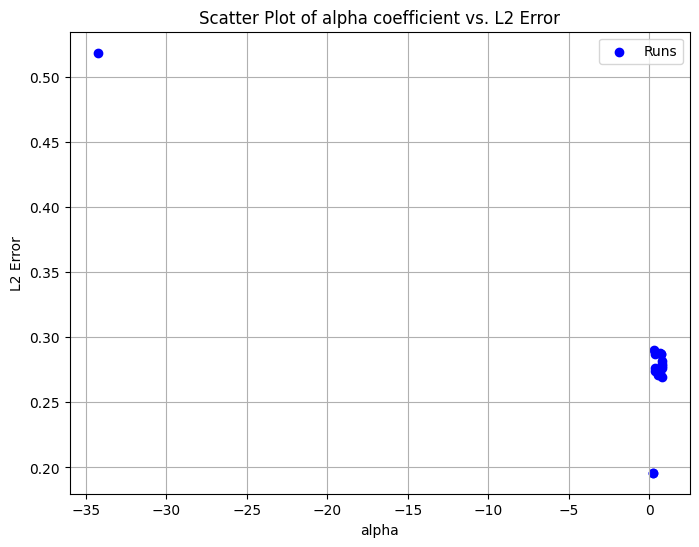

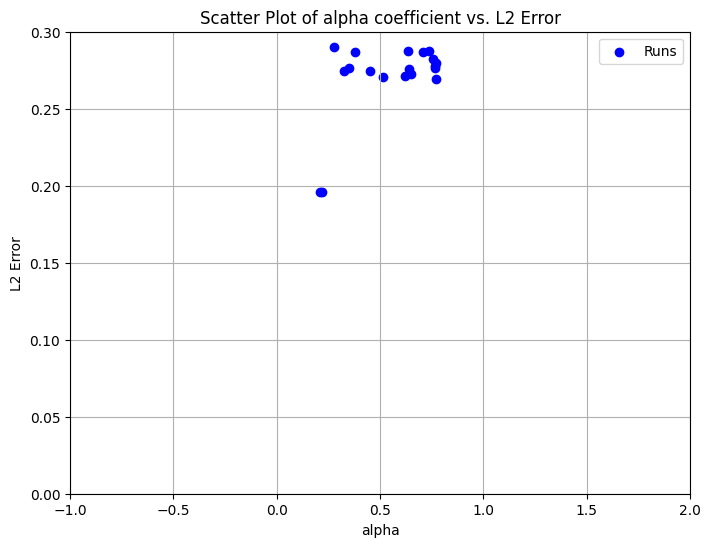

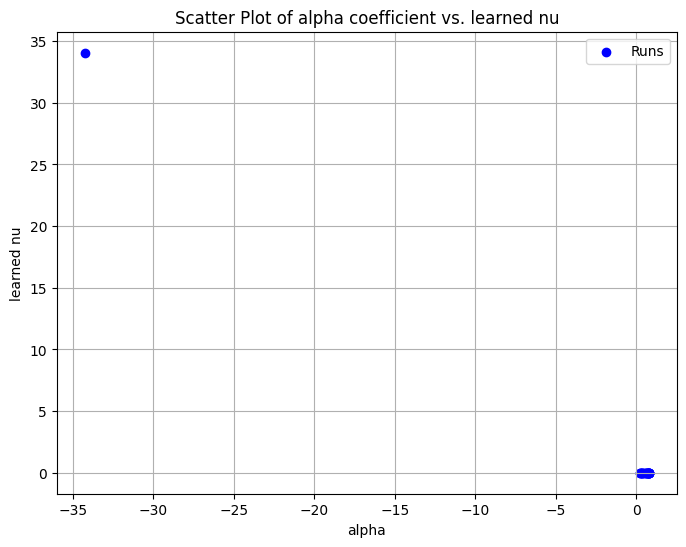

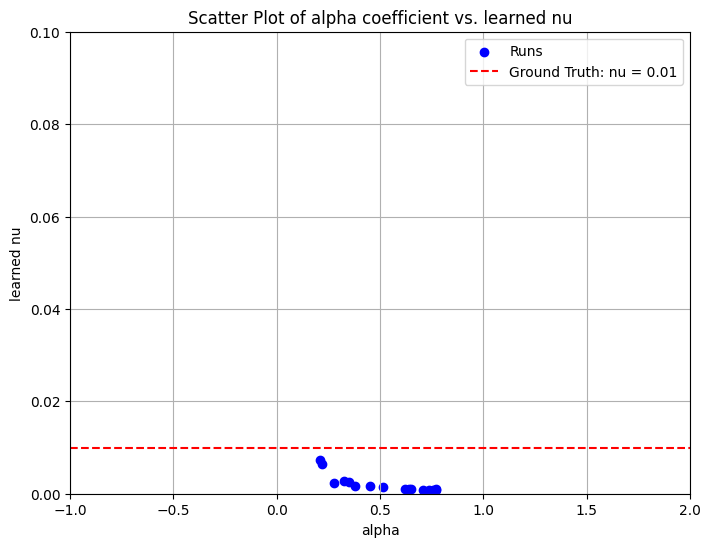

In [12]:
import matplotlib.pyplot as plt
print("alpha list:", alpha_list)
print("learned nu list:", learned_nu_list)
print("velocity l2 error:", l2_error_list)

# L2 Error
plt.figure(figsize=(8, 6))
plt.scatter(alpha_list, l2_error_list, c='b', marker='o', label='Runs')
plt.xlabel('alpha')
plt.ylabel('L2 Error')
plt.title('Scatter Plot of alpha coefficient vs. L2 Error')
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(8, 6))
plt.scatter(alpha_list, l2_error_list, c='b', marker='o', label='Runs')
plt.xlabel('alpha')
plt.ylabel('L2 Error')
plt.title('Scatter Plot of alpha coefficient vs. L2 Error')
plt.legend()
# Limit the x and y label ranges
plt.xlim(-1, 2)  # Set the desired x-axis range
plt.ylim(0, 0.3)  # Set the desired y-axis range
plt.grid(True)
plt.show()

# learned nu
plt.figure(figsize=(8, 6))
plt.scatter(alpha_list, learned_nu_list, c='b', marker='o', label='Runs')
plt.xlabel('alpha')
plt.ylabel('learned nu')
plt.title('Scatter Plot of alpha coefficient vs. learned nu')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(alpha_list, learned_nu_list, c='b', marker='o', label='Runs')
plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')

plt.xlabel('alpha')
plt.ylabel('learned nu')
plt.title('Scatter Plot of alpha coefficient vs. learned nu')
plt.legend()
# Limit the x and y label ranges
plt.xlim(-1, 2)  # Set the desired x-axis range
plt.ylim(0, 0.1)  # Set the desired y-axis range
plt.grid(True)
plt.show()

In [4]:
# v?? 19 Oct 2023 

# nu / np.pi yes
# batch_size [1024, 1024, 1024]
# lr = 0.005
# learned_nu at around 0.0001
# learnabe alpha

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import griddata

class Domain:
    def __init__(self, x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v, batch_size,
                 alpha_initial):
        self.x_min = x_min
        self.x_max = x_max
        self.t_min = t_min
        self.t_max = t_max
        self.num_x = num_x
        self.num_t = num_t
        self.batch_size_r = batch_size[0]
        self.batch_size_0 = batch_size[1]
        self.batch_size_b = batch_size[2]
        self.viscosity = tf.Variable(initial_value=viscosity_init_v, 
                                     trainable=True, 
                                     dtype=tf.float32,
                                     name="artificial_viscosity")
        self.alpha = tf.Variable(initial_value=tf.ones([]) * alpha_initial,
                                 trainable=False,
                                 dtype=tf.float32,
                                 name="nu_loss_coefficient")
        self.t_shock = tf.Variable(initial_value=0.5, 
                                   trainable=True,
                                   dtype=tf.float32,
                                   name="shock_happen_time")
        self.std_dev = tf.Variable(initial_value=0.3,
                                   trainable=True,
                                   dtype=tf.float32,
                                   name="standard_deviation_for_GD")
    
# Define the initial condition
def initial_condition(domain, x):
    # initial_output = np.where(x > 0, 1, 0)
    initial_output = -np.sin(np.pi * x)
    return initial_output 

# Define the boundary conditions
def boundary_conditions(domain, x, t):
    return np.zeros_like(x)

def viscosity_mapping(x, t):
    nu_map = np.where(t >= domain.t_shock, np.exp(-((x - 0) ** 2) / (2 * domain.std_dev ** 2)), 0) # * domain.theta  # gaussian_distribution
    scaled_nu_map = (nu_map - np.min(nu_map)) / (np.max(nu_map) - np.min(nu_map))
    viscosity = domain.viscosity * scaled_nu_map # tf.sigmoid(nu_map)
    storage = [x, t, nu_map, viscosity] # parameter_s components: 0x, 1t, 2theta, 3nu, 4epoch
    return storage 

# Define the physics-informed loss function
def physics_informed_loss(network, domain, x, t, batch_size):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        t_shock_broadcasted = tf.fill(x.shape, domain.t_shock) # make shape compatible for the network inputs [epoch_number,1]
        std_dev_broadcasted = tf.fill(x.shape, domain.std_dev) # make shape compatible for the network inputs [epoch_number,1]
        u = network(tf.concat([x, t, t_shock_broadcasted, std_dev_broadcasted], axis=1))

        u_x = tape.gradient(u, x) # cancel: Reshape x to [32,1]
        u_t = tape.gradient(u, t) # solved: u_t showed NoneType
        u_xx = tape.gradient(u_x, x)

        # Debugging: Check if any tensors contain NaN values
        tf.debugging.assert_all_finite(u_x, "u_x contains NaN values")
        tf.debugging.assert_all_finite(u_t, "u_t contains NaN values")

        # define the parametric viscosity map with the collocation points in the residual learning batch
        # keep record of the parameters: x_coords, t_coords, theta, product of nu_max and nu_map
        parameter_storage = viscosity_mapping(x, t)

        # Define the Burgers equation residual
        residual = u_t + u * u_x - parameter_storage[3] * u_xx
    
    # Define the boundary and initial condition residuals # Done_TODO check "u" LR
    # Compute the loss for initial condition
    num_batch_size_0 = domain.batch_size_0
    t_batch_0 = tf.fill([num_batch_size_0, 1], 0.0001) # considered as 0
    x_batch_0 = tf.random.uniform([num_batch_size_0, 1], minval=domain.x_min, maxval=domain.x_max)
    u_0 = network(tf.concat([x_batch_0, t_batch_0, 
                             tf.fill(x_batch_0.shape, domain.t_shock), 
                             tf.fill(x_batch_0.shape, domain.std_dev)], axis=1))
    initial_residual = u_0 - initial_condition(domain, x_batch_0)

    # Compute the loss for boundary condition
    num_batch_size_b = domain.batch_size_b
    x_batch_bl = tf.cast(tf.fill([num_batch_size_b, 1], -1), dtype=tf.float32)
    x_batch_br = tf.cast(tf.fill([num_batch_size_b, 1], 1), dtype=tf.float32)
    t_batch_b  = tf.random.uniform([num_batch_size_b, 1], minval=domain.t_min, maxval=domain.t_max)
    u_bl = network(tf.concat([x_batch_bl, t_batch_b, 
                              tf.fill(x_batch_bl.shape, domain.t_shock), 
                              tf.fill(x_batch_bl.shape, domain.std_dev)], axis=1)) # int32 and float incompatible
    u_br = network(tf.concat([x_batch_br, t_batch_b, 
                              tf.fill(x_batch_br.shape, domain.t_shock),
                              tf.fill(x_batch_br.shape, domain.std_dev)], axis=1))
    lower_boundary_residual = u_bl - boundary_conditions(domain, x_batch_bl, t_batch_b)
    upper_boundary_residual = u_br - boundary_conditions(domain, x_batch_br, t_batch_b)

    viscosity_loss = tf.square(domain.viscosity) 

    loss = tf.reduce_mean(tf.square(residual)) / batch_size + \
           tf.reduce_mean(tf.square(initial_residual)) / num_batch_size_0 + \
           tf.reduce_mean(tf.square(lower_boundary_residual)) / num_batch_size_b + \
           tf.reduce_mean(tf.square(upper_boundary_residual)) / num_batch_size_b + \
            domain.alpha * viscosity_loss
    
    return loss, parameter_storage

# Define the neural network model
def create_network():
    network = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(4,)),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    return network

# Train the model using PINNs
def train_model(network, domain, num_epochs, learning_rate):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Lists to store loss and viscosity values for each epoch
    history = [[] for _ in range(3)]  # Initialize history as a list with three empty lists
    # history components, [0]: loss, [1]: nu, [2]: alpha

    for epoch in range(num_epochs):
        x_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.x_min, maxval=domain.x_max)
        t_batch = tf.random.uniform([domain.batch_size_r, 1], minval=domain.t_min, maxval=domain.t_max)

        with tf.GradientTape() as tape:
            loss, parameter_s = physics_informed_loss(network, domain, x_batch, t_batch, domain.batch_size_r)

        # add viscosity into the trainable variables from TF
        variable_list = network.trainable_variables + [domain.viscosity] # + [domain.alpha]

        gradients = tape.gradient(loss, variable_list)
        # # Update αvisc based on negative gradient
        # alpha_update = -learning_rate * gradients[-1]  # Negative gradient ascent
        # domain.alpha.assign_add(alpha_update)

        # # Apply gradients to the network weights
        # # optimizer.apply_gradients(zip(gradients[:-2], variable_list[:-2]))
        optimizer.apply_gradients(zip(gradients, variable_list))

        # if epoch % 100 == 0:
        #     print(f"Epoch {epoch}, Loss: {loss.numpy()}")

        if epoch % 10 == 0:
            # Append the loss and viscosity values to the history lists
            history[0].append(loss.numpy())
            history[1].append(domain.viscosity.numpy())
            history[2].append(domain.alpha.numpy())
    
    return network, history, parameter_s

# Visualize the results
def visualize_results(model, domain, history, num_epochs, parameter_s):
    x_grid, t_grid = np.meshgrid(np.linspace(domain.x_min, domain.x_max, domain.num_x),
                                 np.linspace(domain.t_min, domain.t_max, domain.num_t))
    t_shock_grid = np.full_like(x_grid, domain.t_shock)
    std_dev_grid = np.full_like(x_grid, domain.std_dev)
    X = np.hstack((x_grid.flatten()[:, tf.newaxis], 
                   t_grid.flatten()[:, tf.newaxis], 
                   t_shock_grid.flatten()[:, tf.newaxis],
                   std_dev_grid.flatten()[:, tf.newaxis]))
    u_pred_grid = model.predict(X)
    u_pred_grid = griddata(X[:, 0:2], u_pred_grid.flatten(), (x_grid, t_grid), method='cubic')

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(x_grid, t_grid, u_pred_grid, cmap='viridis')

    # Set labels and title
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(x, t)')
    plt.title('Plot of u(x, t)')
    plt.show()

    # print("u_pred_shape:", u_pred_grid.shape)

    plt.figure(figsize=(8, 6))
    plt.pcolor(x_grid, t_grid, u_pred_grid, cmap='jet')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('Predicted Velocity')
    plt.show()

    # Define the x-axis labels at intervals of every 10 epochs
    x_labels = list(range(0, num_epochs, 10))

    # Plot the loss and viscosity trajectories
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_labels, history[0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Trajectory')

    plt.subplot(1, 2, 2)
    plt.plot(x_labels, history[1])
    plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')
    plt.xlabel('Epoch')
    plt.ylabel('Viscosity')
    plt.title('Viscosity Trajectory')

    plt.figure(figsize=(6, 6))
    plt.plot(x_labels, history[2])
    plt.xlabel('Epoch')
    plt.ylabel('alpha')
    plt.title('Alpha Trajectory')

    plt.legend()
    plt.tight_layout()
    plt.show()


    # plot the viscosity map
    # parameter_s components: 0x, 1t, 2nu_map, 3nu, 4epoch
    x_coords = np.array(parameter_s[0])  # Convert to NumPy array
    y_coords = np.array(parameter_s[1])  # Convert to NumPy array
    nu_map = np.array(parameter_s[2])     # Convert to NumPy array
    nu = np.array(parameter_s[3])         # Convert to NumPy array
    # epoch = np.array(parameter_s[4])
    # print("epoch:", epoch)

    # Create the scatter plot

    plt.figure(figsize=(8, 6))
    scatter1 = plt.scatter(x_coords, y_coords, c=nu_map, cmap='viridis', s=50)  # Adjust 's' for point size
    plt.colorbar(scatter1)
    plt.xlabel('X Coordinate')
    plt.ylabel('T Coordinate')
    plt.title('Scatter Plot for nu_map Values')

    plt.figure(figsize=(8, 6))
    scatter2 = plt.scatter(x_coords, y_coords, c=nu, cmap='viridis', s=50)  # Adjust 's' for point size
    plt.colorbar(scatter2)
    plt.xlabel('X Coordinate')
    plt.ylabel('T Coordinate')
    plt.title('Scatter Plot for Viscosity Map Values')

    # Create a histogram of nu
    plt.figure(figsize=(8, 6))
    plt.hist(nu, bins=30)  # You can adjust the number of bins as needed
    plt.title('"nu_max * nu_map (actual viscosity applied to eqt.)" Distribution')
    plt.xlabel('Viscosity Value')
    plt.ylabel('Count')
    plt.grid(axis='y')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    return u_pred_grid


class DomainND:
    def __init__(self, var, time_var=None):
        self.vars = var
        self.domaindict = []
        self.domain_ids = []
        self.time_var = time_var

    # def generate_collocation_points(self, N_f):
    #     range_list = [
    #         [val for key, val in dict_.items() if "range" in key][0]
    #         for dict_ in self.domaindict
    #     ]

    #     limits = np.array(range_list)  # x,t domain
    #     X_f = LatinHypercubeSample(N_f, limits)
    #     self.X_f = X_f

    def add(self, token, vals, fidel):
        self.domain_ids.append(token)
        self.domaindict.append({
            "identifier": token,
            "range": vals,
            (token + "fidelity"): fidel,
            (token + "linspace"): np.linspace(vals[0], vals[1], fidel),
            (token + "upper"): vals[1],
            (token + "lower"): vals[0]
        })

if __name__ == "__main__":
    num_run = 10
    # create lists to store results for each run
    learned_nu_list = []
    l2_error_list = []
    alpha_list = []

        
    DomainND = DomainND(["x", "t"], time_var='t')

    DomainND.add("x", [-1.0, 1.0], 256)
    DomainND.add("t", [0.0, 1.0], 100)

    # input data
    data = scipy.io.loadmat('burgers_shock.mat')
    Exact = data['usol']
    Exact_u = np.real(Exact) # shape of [256, 100]
    x = DomainND.domaindict[0]['xlinspace']
    t = DomainND.domaindict[1]["tlinspace"]

    X, T = np.meshgrid(x, t)

    for run in range(num_run):
        # clear previous TensorFlow graph and session
        tf.keras.backend.clear_session()
        # tf.reset_default_graph() # no in tf v2.x
        
        # Define domain parameters and create the domain
        x_min = -1.0
        x_max = 1.0
        t_min = 0
        t_max = 1.00
        num_x = 256
        num_t = 100
        batch_size_r=1024
        num_batch_size_0 = 1024
        num_batch_size_b = 1024
        batch_size = [batch_size_r, num_batch_size_0, num_batch_size_b] # define batch_size list 
        viscosity_init_v = tf.random.uniform(shape=(), minval=0.001, maxval=1.0)
        num_epochs = 2000
        alpha_initial = np.linspace(0.06, 0.16, num_run)

        domain = Domain(x_min, x_max, t_min, t_max, num_x, num_t, viscosity_init_v, batch_size, alpha_initial[run])

        # print(np.shape((X,T))) #2, 100, 256
        t_shock_grid = np.full_like(X, domain.t_shock)
        std_dev_grid = np.full_like(T, domain.std_dev)

        X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None],
                            t_shock_grid.flatten()[:, None],
                            std_dev_grid.flatten()[:, None]))
        u_star = Exact_u.T.flatten()[:, None] # shape of [25600, 1]
        # print("exact_u shape:", Exact_u.shape)
        # print("u_star shape:", u_star.shape)
        # u_star_2 = griddata(X_star, u_star.flatten(), (X, T), method='cubic')
        # print("u_star 2 shape:", u_star_2.shape) 

        # Create the neural network 
        network = create_network()

        # Train the model using PINNs
        model, history, parameter_s = train_model(network, 
                                    domain, 
                                    num_epochs,
                                    learning_rate=0.01
                                    )

        # Visualize the results
        # u_pred_grid = visualize_results(model, domain, history, num_epochs, parameter_s)

        u_pred_grid_ND = model.predict(X_star)
        del model

        l2_error = tf.sqrt(tf.reduce_mean(tf.square(u_pred_grid_ND - u_star)))
        # print("L2 error between predicted u and actual u:", l2_error.numpy())
        # print("learned nu:", domain.viscosity.numpy)
        # print("alpha:", domain.alpha)
        # print("batch sizes:", batch_size)
        # print(f"Run {run + 1} - L2 error: {l2_error.numpy()}")
        print(f"Run {run + 1} finished.")

        # Store results in lists
        learned_nu_list.append(domain.viscosity.numpy())
        l2_error_list.append(l2_error.numpy())
        alpha_list.append(domain.alpha.numpy())

        # if hasattr(domain, 't_shock'):
        #     print("t_shock:", domain.t_shock)
        #     print("std_dev:", domain.std_dev)
        # else:
        #     print("Variables 't_shock' and 'std_dev' are not applicable in this AV method.")
    
    
    # Print the results for each run
    for run in range(num_run):
        print(f"Run {run + 1} - alpha: {alpha_list[run]} - Learned nu: {learned_nu_list[run]} - L2 error: {l2_error_list[run]}")

        


KeyboardInterrupt: 

alpha list: [0.06, 0.07111111, 0.08222222, 0.093333334, 0.104444444, 0.115555555, 0.12666667, 0.13777778, 0.14888889, 0.16]
learned nu list: [0.010806344, 0.013963382, 0.010284974, 0.011555127, 0.011899633, 0.009603874, 0.0102665, 0.008620365, 0.0059835324, 0.0075677745]
velocity l2 error: [0.18091590779006633, 0.18729057327226165, 0.17621850767202735, 0.18720950379000328, 0.20557314026114148, 0.18409637724513891, 0.1957057625436024, 0.16299454459863938, 0.26941861126230565, 0.22490986697341273]


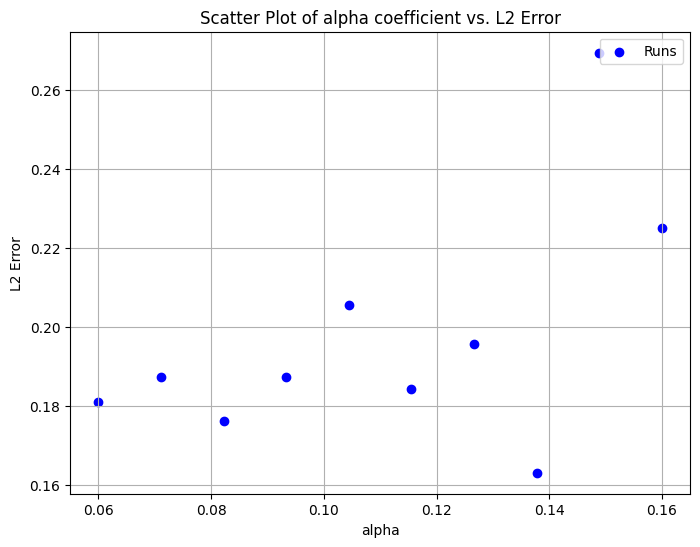

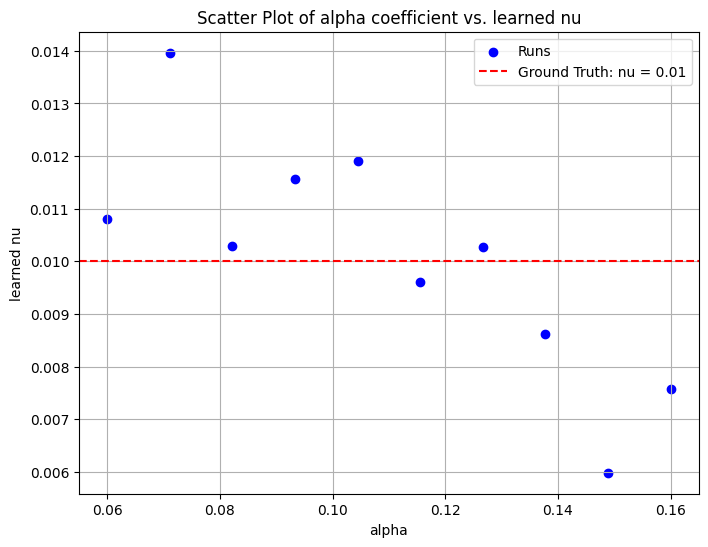

In [3]:
import matplotlib.pyplot as plt
print("alpha list:", alpha_list)
print("learned nu list:", learned_nu_list)
print("velocity l2 error:", l2_error_list)

# L2 Error
plt.figure(figsize=(8, 6))
plt.scatter(alpha_list, l2_error_list, c='b', marker='o', label='Runs')
plt.xlabel('alpha')
plt.ylabel('L2 Error')
plt.title('Scatter Plot of alpha coefficient vs. L2 Error')
plt.legend()
plt.grid(True)
plt.show()
# plt.figure(figsize=(8, 6))
# plt.scatter(alpha_list, l2_error_list, c='b', marker='o', label='Runs')
# plt.xlabel('alpha')
# plt.ylabel('L2 Error')
# plt.title('Scatter Plot of alpha coefficient vs. L2 Error')
# plt.legend()
# # Limit the x and y label ranges
# plt.xlim(-1, 2)  # Set the desired x-axis range
# plt.ylim(0, 0.3)  # Set the desired y-axis range
# plt.grid(True)
# plt.show()

# learned nu
plt.figure(figsize=(8, 6))
plt.scatter(alpha_list, learned_nu_list, c='b', marker='o', label='Runs')
plt.xlabel('alpha')
plt.ylabel('learned nu')
plt.title('Scatter Plot of alpha coefficient vs. learned nu')
plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')

plt.legend()
plt.grid(True)
plt.show()

# plt.figure(figsize=(8, 6))
# plt.scatter(alpha_list, learned_nu_list, c='b', marker='o', label='Runs')
# plt.axhline(y=0.01, color='r', linestyle='--', label='Ground Truth: nu = 0.01')

# plt.xlabel('alpha')
# plt.ylabel('learned nu')
# plt.title('Scatter Plot of alpha coefficient vs. learned nu')
# plt.legend()
# # Limit the x and y label ranges
# plt.xlim(-1, 2)  # Set the desired x-axis range
# plt.ylim(0, 0.1)  # Set the desired y-axis range
# plt.grid(True)
# plt.show()